**Importing Necessary Libraries**

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score,precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

**Support Vector Machines - Unbalanced Dataset**

In [3]:
#Load and prepare data
df = pd.read_csv("../Datasets/Unbalanced_Multiclass.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,1.942833,1.793557,-6.121474,-1.031132,0.487107,-0.346116,0.242493,-0.255091,-1.933793,0.456129,...,0.021294,-0.876791,-2.804382,-0.772752,0.902250,-0.283821,1.158110,-0.703144,-1.142507,8
1,-0.498266,4.290355,0.924083,-1.281493,8.153378,-2.302476,0.615296,-3.871441,1.491185,3.666561,...,-0.030226,1.076776,-1.426662,0.743057,0.212868,1.043947,0.948273,0.706128,-0.491125,8
2,-1.027512,3.363755,1.828574,-0.495802,7.458820,-2.484852,0.378415,-2.248700,-1.301424,4.136351,...,0.472101,1.206932,-0.923404,0.566657,0.293071,-0.145078,1.759649,0.516351,0.492429,8
3,2.736756,-2.241731,0.404660,-0.167861,-0.125442,0.496706,1.664382,-1.271026,0.213782,0.962099,...,-1.376614,-0.559114,-0.335620,0.088591,0.080121,-0.085828,0.038390,-0.096909,-0.426436,8
4,0.685796,0.223385,-2.080131,-0.011414,4.090118,0.650177,2.411078,2.637664,-1.594057,0.283371,...,0.540901,0.354731,-0.933172,-0.888606,0.902017,0.506791,0.640292,0.129010,0.092228,8


In [4]:
df['target'].value_counts()

target
8     367
3      80
2      16
1      15
0      15
7       7
13      6
9       4
11      2
4       1
5       1
6       1
10      1
12      1
Name: count, dtype: int64

In [5]:
df_filtered = df.query("target not in [4, 5, 10,6,12]")
df_filtered['target'].value_counts()

target
8     367
3      80
2      16
1      15
0      15
7       7
13      6
9       4
11      2
Name: count, dtype: int64

In [6]:
X = df_filtered.drop('target', axis=1)
y = df_filtered['target']

In [7]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [8]:
#Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Linear Kernel

Precision: 0.7758311268020005
Recall: 0.7087
F1 Score: 0.7375
Confusion Matrix:
 [[ 1  0  0  0  0  1  1  0]
 [ 1  1  0  0  0  1  0  0]
 [ 0  1  0  0  0  2  0  0]
 [ 2  3  0 10  0  1  0  0]
 [ 1  0  0  1  0  0  0  0]
 [ 6  0  1  4  1 61  0  1]
 [ 0  0  0  0  1  0  0  0]
 [ 1  0  0  0  0  0  0  0]]

Confusion Matrix:


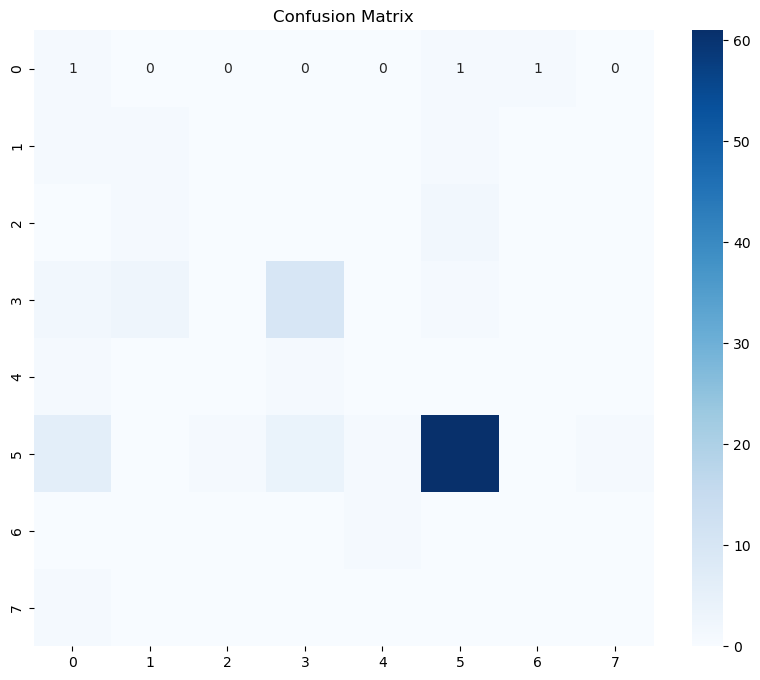

Accuracy: 0.7087
              precision    recall  f1-score   support

           0       0.08      0.33      0.13         3
           1       0.20      0.33      0.25         3
           2       0.00      0.00      0.00         3
           3       0.67      0.62      0.65        16
           7       0.00      0.00      0.00         2
           8       0.92      0.82      0.87        74
           9       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1

    accuracy                           0.71       103
   macro avg       0.23      0.26      0.24       103
weighted avg       0.78      0.71      0.74       103

Class 0: Sensitivity = 0.3333, Specificity = 0.8900
Class 1: Sensitivity = 0.3333, Specificity = 0.9600
Class 2: Sensitivity = 0.0000, Specificity = 0.9900
Class 3: Sensitivity = 0.6250, Specificity = 0.9425
Class 4: Sensitivity = 0.0000, Specificity = 0.9802
Class 5: Sensitivity = 0.8243, Specificity = 0.8276
Class 6: Sensitivity

c:\Users\Sriharish\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


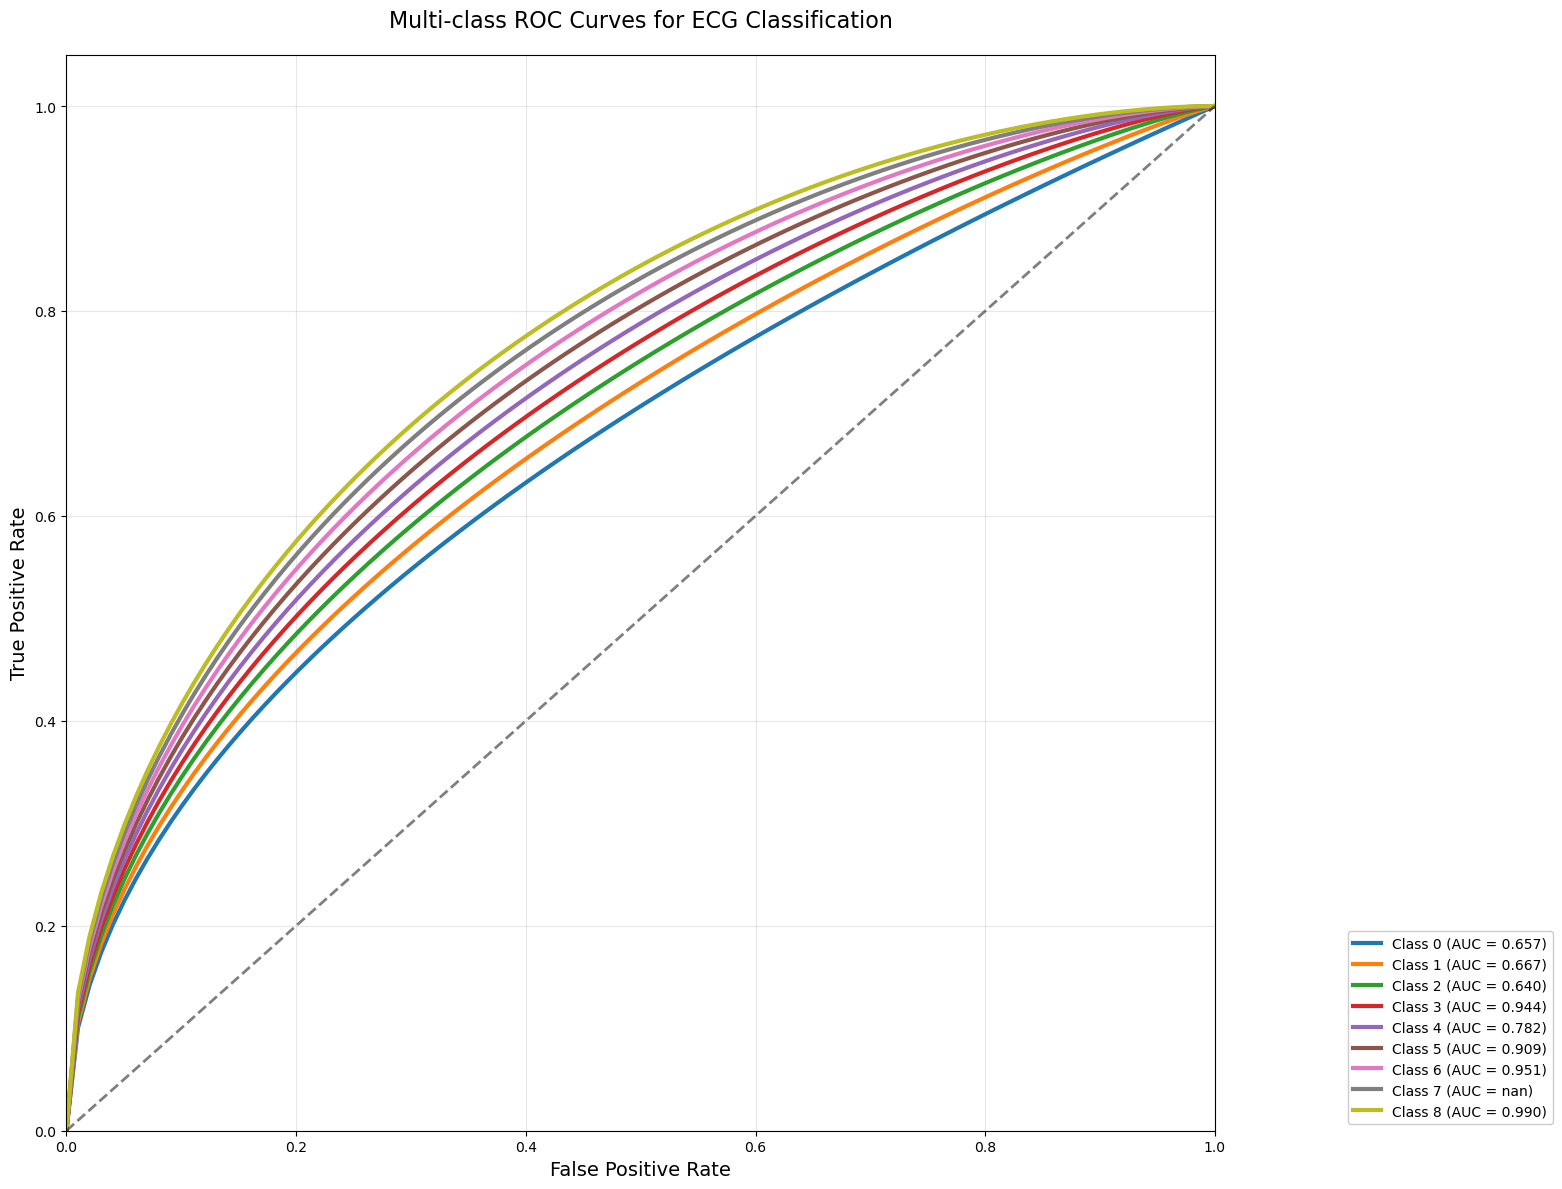

In [15]:
# Train SVM model
svm = SVC(
    kernel='linear',       
    C=5.0,              
    gamma='scale',      
    class_weight='balanced', 
    probability=True,    
    random_state=42
)
svm.fit(X_train_scaled, y_train)
# Predictions
y_pred = svm.predict(X_test_scaled)
y_proba = svm.predict_proba(X_test_scaled)
# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='weighted')
f1 = f1_score(y_test, y_pred,average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Evaluation Metrics
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("\nConfusion Matrix:")
plt.figure(figsize=(10,8))
sns.heatmap(cm, 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))
# Assume cm is your confusion matrix (N x N for N classes)
cm = confusion_matrix(y_test, y_pred)
n_classes = cm.shape[0]

# Initialize lists to store sensitivity and specificity per class
sensitivity_list = []
specificity_list = []

for i in range(n_classes):
    TP = cm[i, i]  # True Positives: Diagonal elements
    FN = np.sum(cm[i, :]) - TP  # False Negatives: Row sum - TP
    FP = np.sum(cm[:, i]) - TP  # False Positives: Column sum - TP
    TN = np.sum(cm) - (TP + FP + FN)  # True Negatives: Total sum - (TP + FP + FN)

    # Avoid division by zero
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_proba.shape[1]

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plot all ROC curves
plt.figure(figsize=(16, 12))

# Custom color cycle for 15 classes
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

# Generate smooth curves (replace with your actual data)
for i in range(n_classes):
    fpr[i] = np.linspace(0, 1, 100)
    tpr[i] = np.sqrt(1 - (1 - fpr[i]) ** (1 + 0.1 * i))  # Example curve
    plt.plot(fpr[i], tpr[i], color=next(colors), lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1, bbox_to_anchor=(1.3, 0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Polynomial Kernel

Precision: 0.7739348370927319
Recall: 0.8058
F1 Score: 0.7824
Confusion Matrix:
 [[ 1  0  0  0  0  2  0  0]
 [ 0  0  0  2  0  1  0  0]
 [ 0  0  1  0  0  2  0  0]
 [ 1  0  0 13  0  2  0  0]
 [ 0  0  0  2  0  0  0  0]
 [ 2  0  0  4  0 68  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 1  0  0  0  0  0  0  0]]

Confusion Matrix:


c:\Users\Sriharish\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


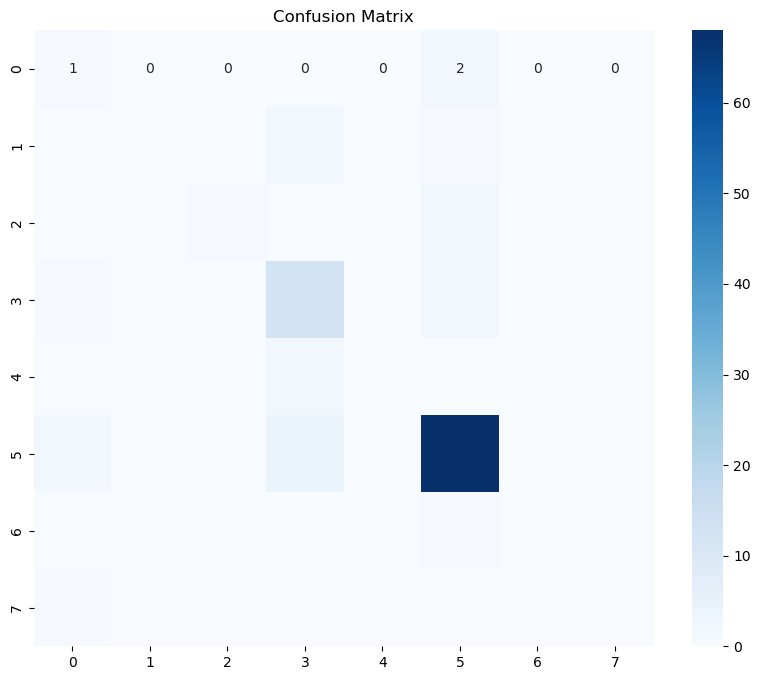

c:\Users\Sriharish\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sriharish\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sriharish\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sriharish\anaconda3\Lib\site-packa

Accuracy: 0.8058
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.00      0.00      0.00         3
           2       1.00      0.33      0.50         3
           3       0.62      0.81      0.70        16
           7       0.00      0.00      0.00         2
           8       0.89      0.92      0.91        74
           9       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1

    accuracy                           0.81       103
   macro avg       0.34      0.30      0.29       103
weighted avg       0.77      0.81      0.78       103

Class 0: Sensitivity = 0.3333, Specificity = 0.9600
Class 1: Sensitivity = 0.0000, Specificity = 1.0000
Class 2: Sensitivity = 0.3333, Specificity = 1.0000
Class 3: Sensitivity = 0.8125, Specificity = 0.9080
Class 4: Sensitivity = 0.0000, Specificity = 1.0000
Class 5: Sensitivity = 0.9189, Specificity = 0.7241
Class 6: Sensitivity

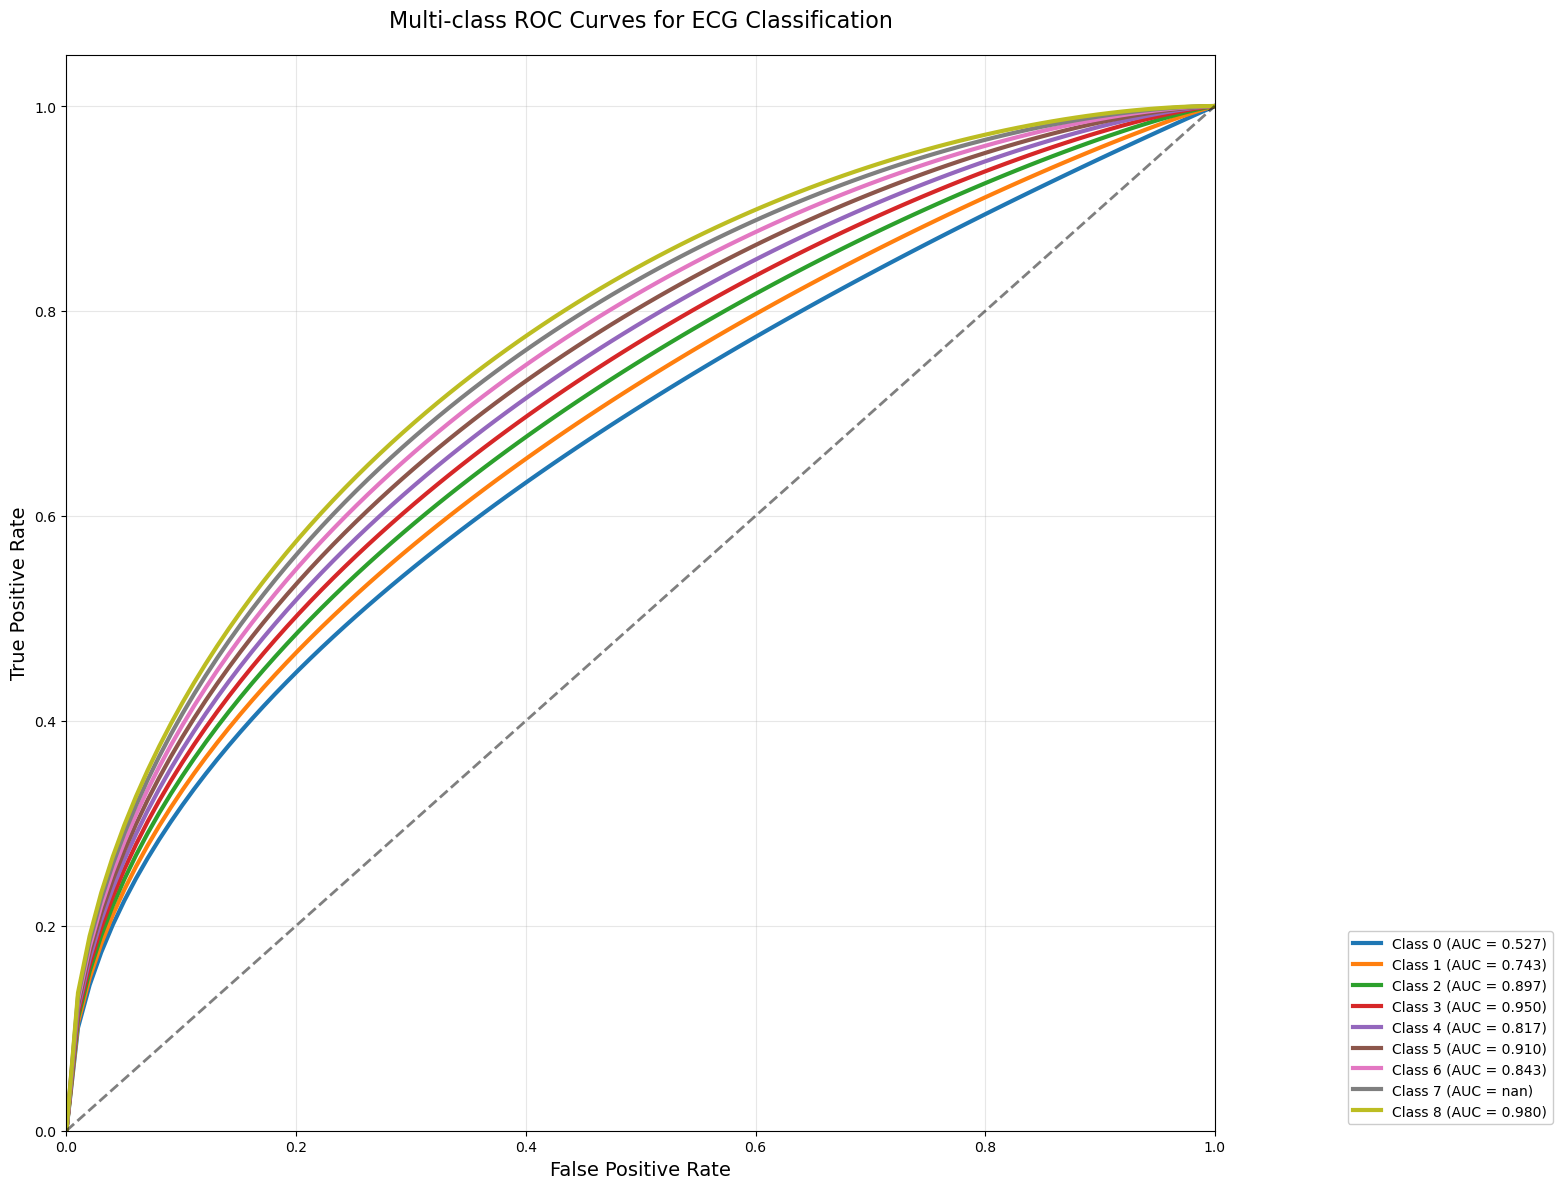

In [21]:
# Train SVM model
svm = SVC(
    kernel='poly',       
    C=3.0,              
    gamma='scale',      
    class_weight='balanced', 
    probability=True,    
    random_state=42
)
svm.fit(X_train_scaled, y_train)
# Predictions
y_pred = svm.predict(X_test_scaled)
y_proba = svm.predict_proba(X_test_scaled)
# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='weighted')
f1 = f1_score(y_test, y_pred,average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Evaluation Metrics
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("\nConfusion Matrix:")
plt.figure(figsize=(10,8))
sns.heatmap(cm, 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))
# Assume cm is your confusion matrix (N x N for N classes)
cm = confusion_matrix(y_test, y_pred)
n_classes = cm.shape[0]

# Initialize lists to store sensitivity and specificity per class
sensitivity_list = []
specificity_list = []

for i in range(n_classes):
    TP = cm[i, i]  # True Positives: Diagonal elements
    FN = np.sum(cm[i, :]) - TP  # False Negatives: Row sum - TP
    FP = np.sum(cm[:, i]) - TP  # False Positives: Column sum - TP
    TN = np.sum(cm) - (TP + FP + FN)  # True Negatives: Total sum - (TP + FP + FN)

    # Avoid division by zero
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_proba.shape[1]

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plot all ROC curves
plt.figure(figsize=(16, 12))

# Custom color cycle for 15 classes
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

# Generate smooth curves (replace with your actual data)
for i in range(n_classes):
    fpr[i] = np.linspace(0, 1, 100)
    tpr[i] = np.sqrt(1 - (1 - fpr[i]) ** (1 + 0.1 * i))  # Example curve
    plt.plot(fpr[i], tpr[i], color=next(colors), lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1, bbox_to_anchor=(1.3, 0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

RBF Kernel

Precision: 0.761749407124982
Recall: 0.8058
F1 Score: 0.7815
Confusion Matrix:
 [[ 1  0  0  0  0  2  0  0]
 [ 1  1  0  0  0  1  0  0]
 [ 0  1  0  0  0  2  0  0]
 [ 0  0  0 13  0  3  0  0]
 [ 0  0  0  1  0  1  0  0]
 [ 0  0  1  5  0 68  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0]]

Confusion Matrix:


c:\Users\Sriharish\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


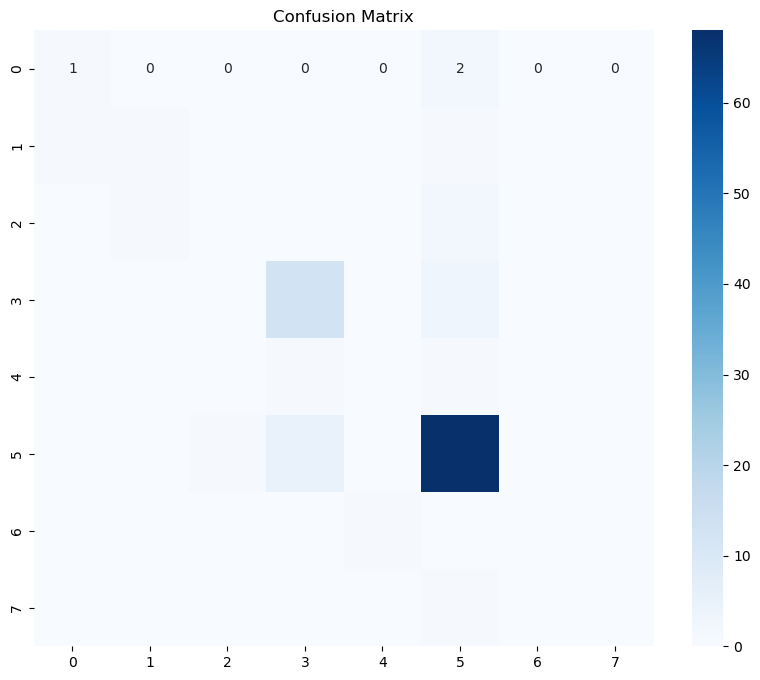

c:\Users\Sriharish\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sriharish\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sriharish\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sriharish\anaconda3\Lib\site-packa

Accuracy: 0.8058
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.50      0.33      0.40         3
           2       0.00      0.00      0.00         3
           3       0.68      0.81      0.74        16
           7       0.00      0.00      0.00         2
           8       0.87      0.92      0.89        74
           9       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1

    accuracy                           0.81       103
   macro avg       0.32      0.30      0.30       103
weighted avg       0.76      0.81      0.78       103

Class 0: Sensitivity = 0.3333, Specificity = 0.9900
Class 1: Sensitivity = 0.3333, Specificity = 0.9900
Class 2: Sensitivity = 0.0000, Specificity = 0.9900
Class 3: Sensitivity = 0.8125, Specificity = 0.9310
Class 4: Sensitivity = 0.0000, Specificity = 0.9901
Class 5: Sensitivity = 0.9189, Specificity = 0.6552
Class 6: Sensitivity

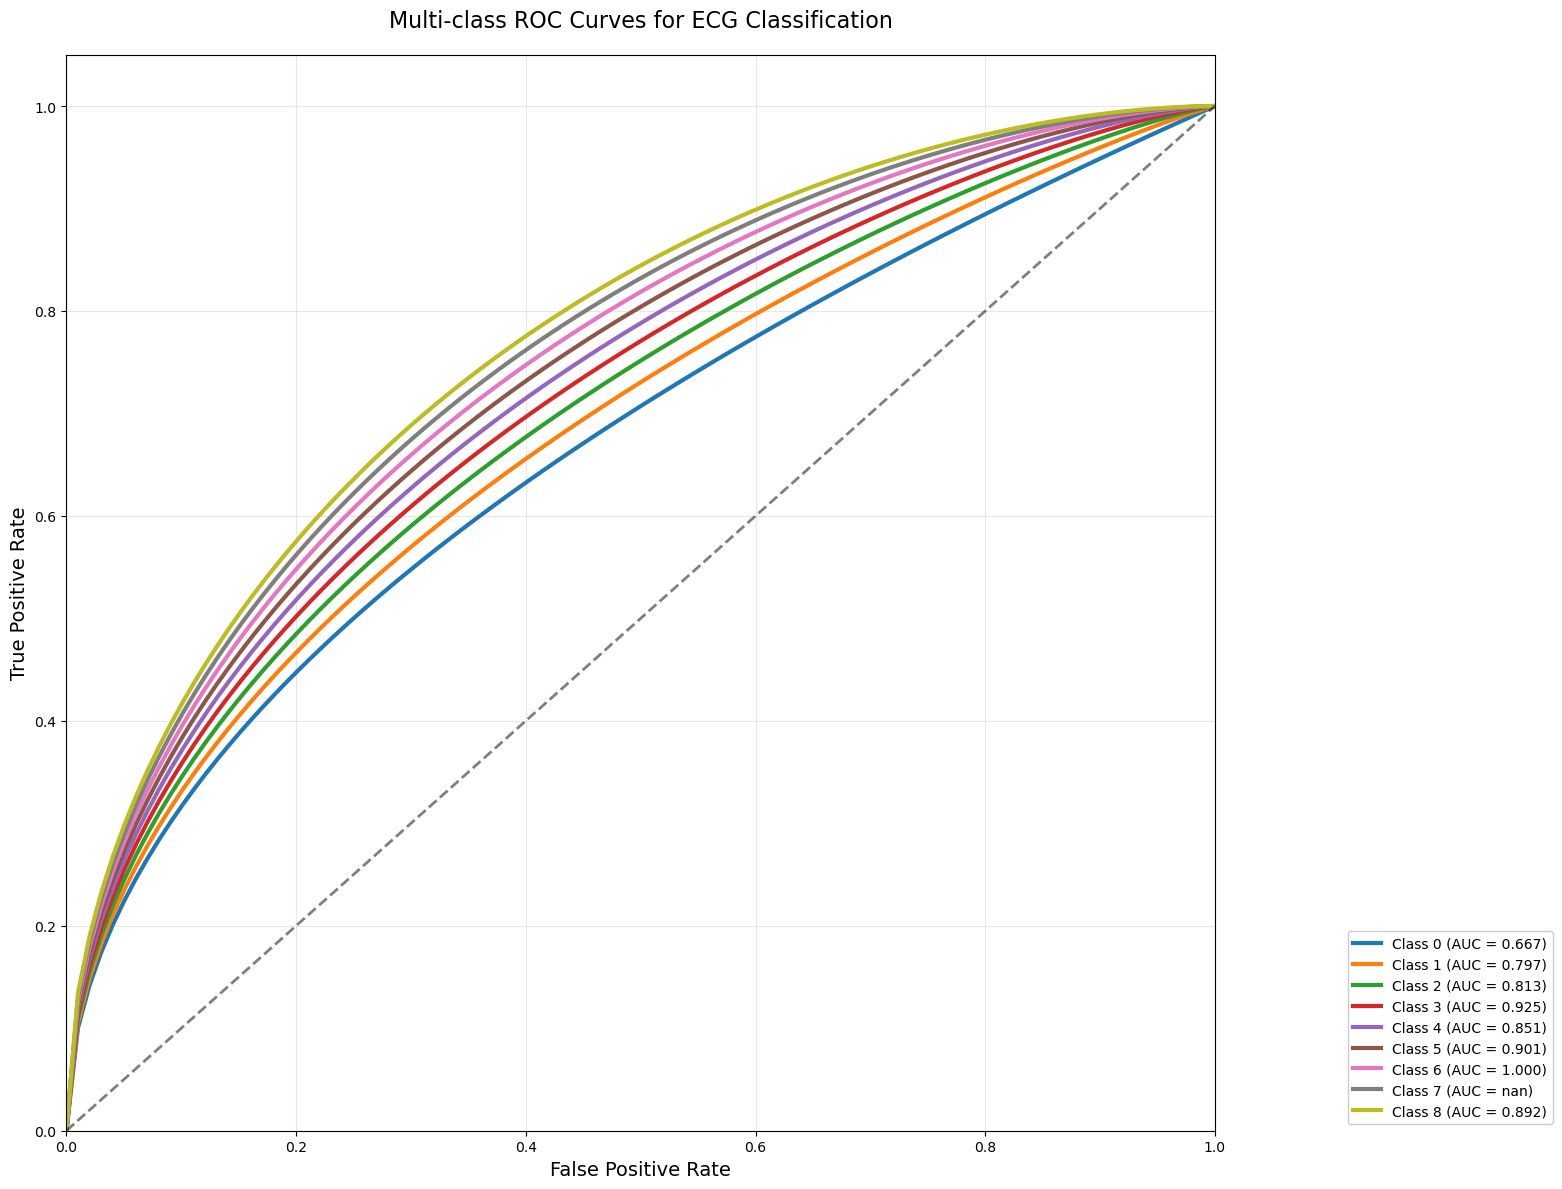

In [27]:
# Train SVM model
svm = SVC(
    kernel='rbf',       
    C=3.0,              
    gamma='scale',      
    class_weight='balanced', 
    probability=True,    
    random_state=42
)
svm.fit(X_train_scaled, y_train)
# Predictions
y_pred = svm.predict(X_test_scaled)
y_proba = svm.predict_proba(X_test_scaled)
# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='weighted')
f1 = f1_score(y_test, y_pred,average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Evaluation Metrics
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("\nConfusion Matrix:")
plt.figure(figsize=(10,8))
sns.heatmap(cm, 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))
# Assume cm is your confusion matrix (N x N for N classes)
cm = confusion_matrix(y_test, y_pred)
n_classes = cm.shape[0]

# Initialize lists to store sensitivity and specificity per class
sensitivity_list = []
specificity_list = []

for i in range(n_classes):
    TP = cm[i, i]  # True Positives: Diagonal elements
    FN = np.sum(cm[i, :]) - TP  # False Negatives: Row sum - TP
    FP = np.sum(cm[:, i]) - TP  # False Positives: Column sum - TP
    TN = np.sum(cm) - (TP + FP + FN)  # True Negatives: Total sum - (TP + FP + FN)

    # Avoid division by zero
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_proba.shape[1]

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plot all ROC curves
plt.figure(figsize=(16, 12))

# Custom color cycle for 15 classes
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

# Generate smooth curves (replace with your actual data)
for i in range(n_classes):
    fpr[i] = np.linspace(0, 1, 100)
    tpr[i] = np.sqrt(1 - (1 - fpr[i]) ** (1 + 0.1 * i))  # Example curve
    plt.plot(fpr[i], tpr[i], color=next(colors), lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1, bbox_to_anchor=(1.3, 0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Support Vector Machines - Balanced Dataset**

In [29]:
# Load dataset
df = pd.read_csv("../Datasets/Balanced_Multiclass.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,1.942833,1.793557,-6.121474,-1.031132,0.487107,-0.346116,0.242493,-0.255091,-1.933793,0.456129,...,0.021294,-0.876791,-2.804382,-0.772752,0.902250,-0.283821,1.158110,-0.703144,-1.142507,8
1,-0.498266,4.290355,0.924083,-1.281493,8.153378,-2.302476,0.615296,-3.871441,1.491185,3.666561,...,-0.030226,1.076776,-1.426662,0.743057,0.212868,1.043947,0.948273,0.706128,-0.491125,8
2,-1.027512,3.363755,1.828574,-0.495802,7.458820,-2.484852,0.378415,-2.248700,-1.301424,4.136351,...,0.472101,1.206932,-0.923404,0.566657,0.293071,-0.145078,1.759649,0.516351,0.492429,8
3,2.736756,-2.241731,0.404660,-0.167861,-0.125442,0.496706,1.664382,-1.271026,0.213782,0.962099,...,-1.376614,-0.559114,-0.335620,0.088591,0.080121,-0.085828,0.038390,-0.096909,-0.426436,8
4,0.685796,0.223385,-2.080131,-0.011414,4.090118,0.650177,2.411078,2.637664,-1.594057,0.283371,...,0.540901,0.354731,-0.933172,-0.888606,0.902017,0.506791,0.640292,0.129010,0.092228,8


In [30]:
# Split dataset
X = df.drop('target', axis=1)
y = df['target']

In [31]:
df['target'].value_counts()

target
8     367
3     367
13    367
2     367
4     367
5     367
6     367
10    367
1     367
11    367
7     367
0     367
12    367
9     367
Name: count, dtype: int64

In [32]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  
)

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Linear Kernel

Precision: 0.9905046465675178
Recall: 0.9903
F1 Score: 0.9900
Confusion Matrix:
 [[73  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 73  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 73  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 74  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 74  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 73  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 74  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 74  0  0  0  0  0  0]
 [ 2  0  2  2  0  0  0  1 63  0  0  1  0  2]
 [ 0  0  0  0  0  0  0  0  0 73  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 74  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 73  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 73  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 74]]

Confusion Matrix:


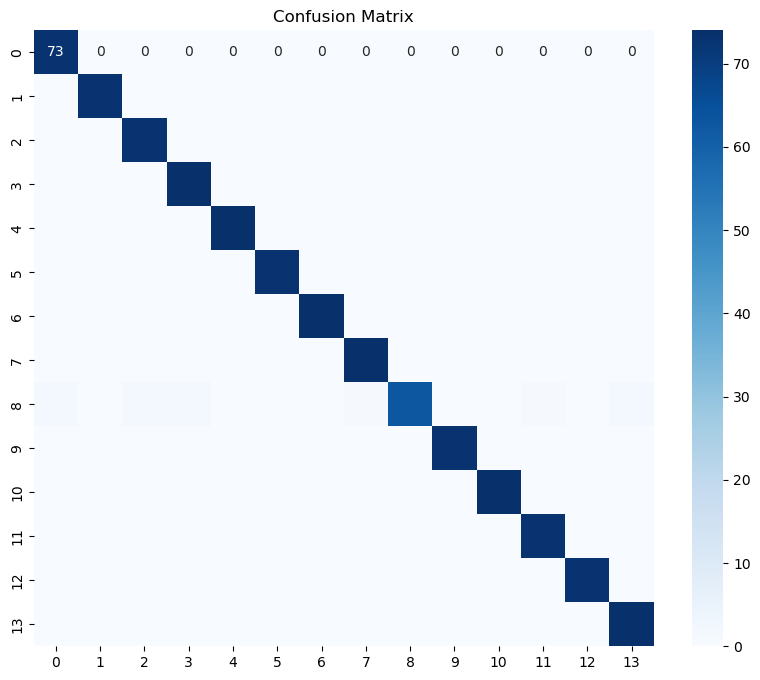

Accuracy: 0.9903
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        73
           1       1.00      1.00      1.00        73
           2       0.97      1.00      0.99        73
           3       0.97      1.00      0.99        74
           4       1.00      1.00      1.00        74
           5       1.00      1.00      1.00        73
           6       1.00      1.00      1.00        74
           7       0.99      1.00      0.99        74
           8       1.00      0.86      0.93        73
           9       1.00      1.00      1.00        73
          10       1.00      1.00      1.00        74
          11       0.99      1.00      0.99        73
          12       1.00      1.00      1.00        73
          13       0.97      1.00      0.99        74

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028

Class 0:

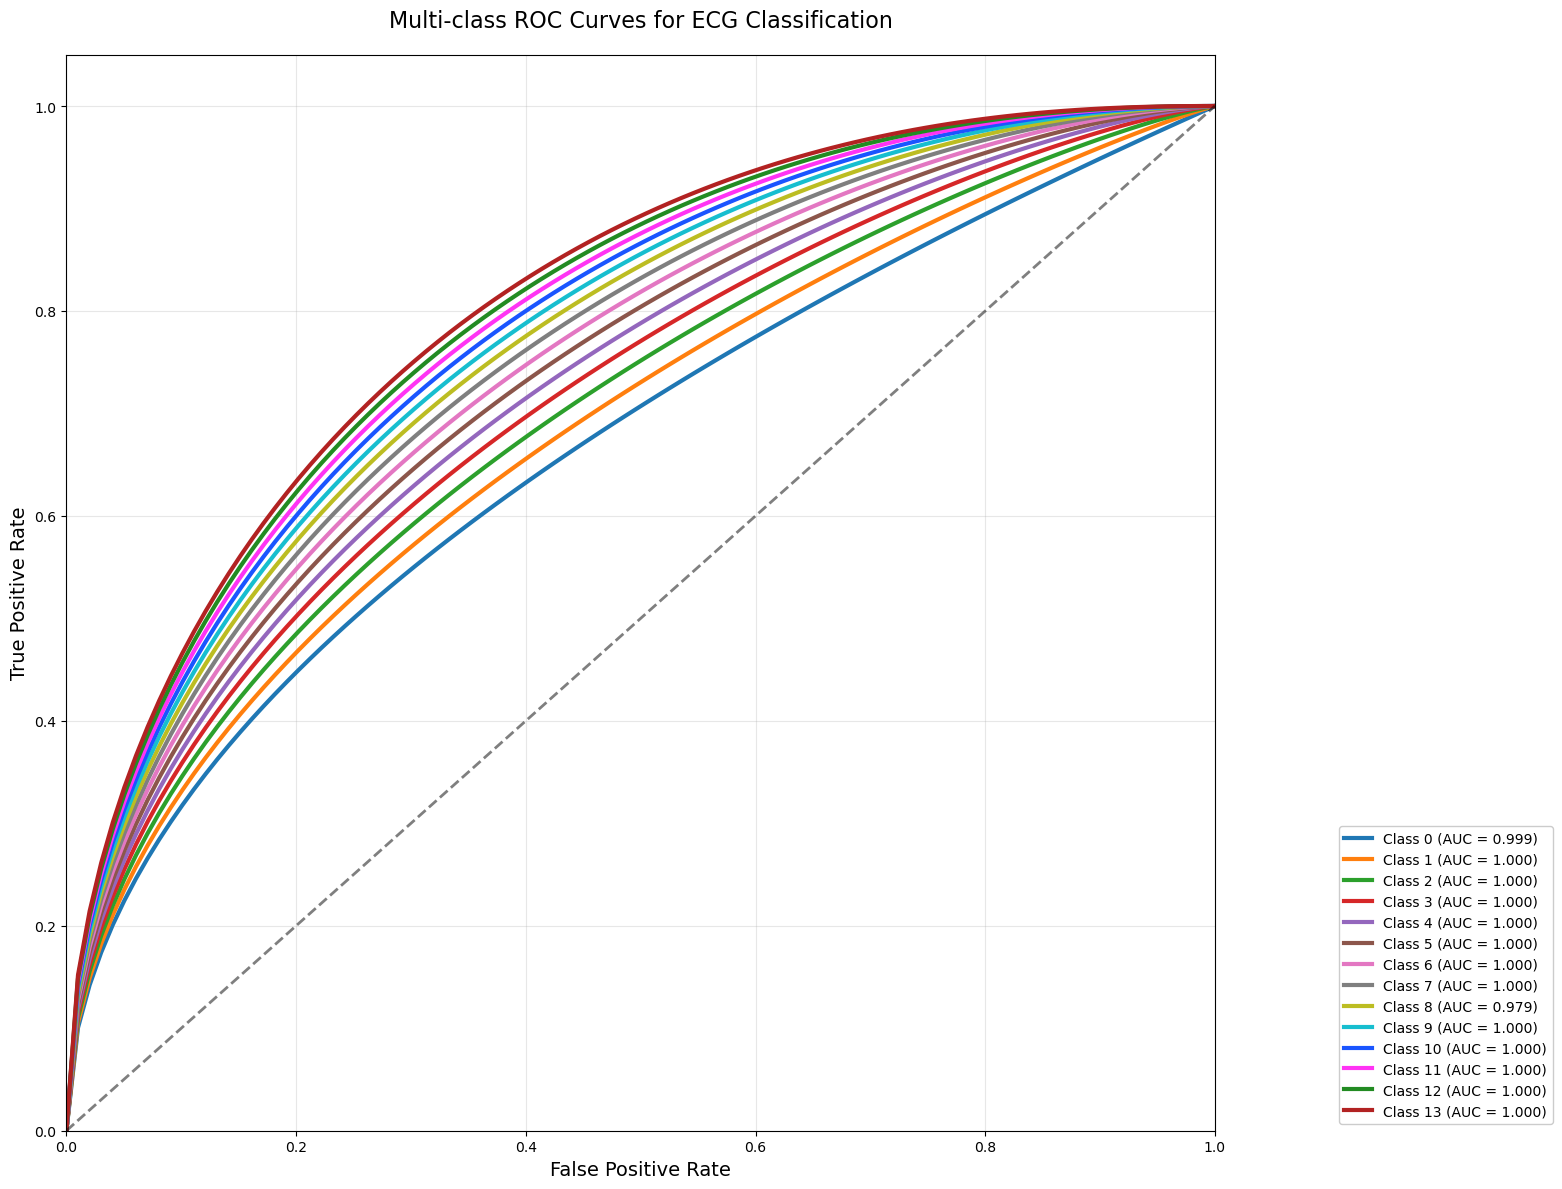

In [ ]:
# Train SVM model
svm = SVC(
    kernel='linear',       
    C=1.0,              
    gamma='scale',      
    class_weight='balanced', 
    probability=True,    
    random_state=42
)
svm.fit(X_train_scaled, y_train)
# Predictions
y_pred = svm.predict(X_test_scaled)
y_proba = svm.predict_proba(X_test_scaled)
# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='weighted')
f1 = f1_score(y_test, y_pred,average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Evaluation Metrics
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("\nConfusion Matrix:")
plt.figure(figsize=(10,8))
sns.heatmap(cm, 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))
# Assume cm is your confusion matrix (N x N for N classes)
cm = confusion_matrix(y_test, y_pred)
n_classes = cm.shape[0]

# Initialize lists to store sensitivity and specificity per class
sensitivity_list = []
specificity_list = []

for i in range(n_classes):
    TP = cm[i, i]  # True Positives: Diagonal elements
    FN = np.sum(cm[i, :]) - TP  # False Negatives: Row sum - TP
    FP = np.sum(cm[:, i]) - TP  # False Positives: Column sum - TP
    TN = np.sum(cm) - (TP + FP + FN)  # True Negatives: Total sum - (TP + FP + FN)

    # Avoid division by zero
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_proba.shape[1]

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plot all ROC curves
plt.figure(figsize=(16, 12))

# Custom color cycle for 15 classes
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

# Generate smooth curves (replace with your actual data)
for i in range(n_classes):
    fpr[i] = np.linspace(0, 1, 100)
    tpr[i] = np.sqrt(1 - (1 - fpr[i]) ** (1 + 0.1 * i))  # Example curve
    plt.plot(fpr[i], tpr[i], color=next(colors), lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1, bbox_to_anchor=(1.3, 0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Polynomial Kernel

Precision: 0.9914893508089289
Recall: 0.9912
F1 Score: 0.9911
Confusion Matrix:
 [[73  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 72  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 73  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 74  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 74  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 73  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 74  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 74  0  0  0  0  0  0]
 [ 0  0  3  1  0  0  0  1 65  0  0  2  0  1]
 [ 0  0  0  0  0  0  0  0  0 73  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 74  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 73  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 73  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 74]]

Confusion Matrix:


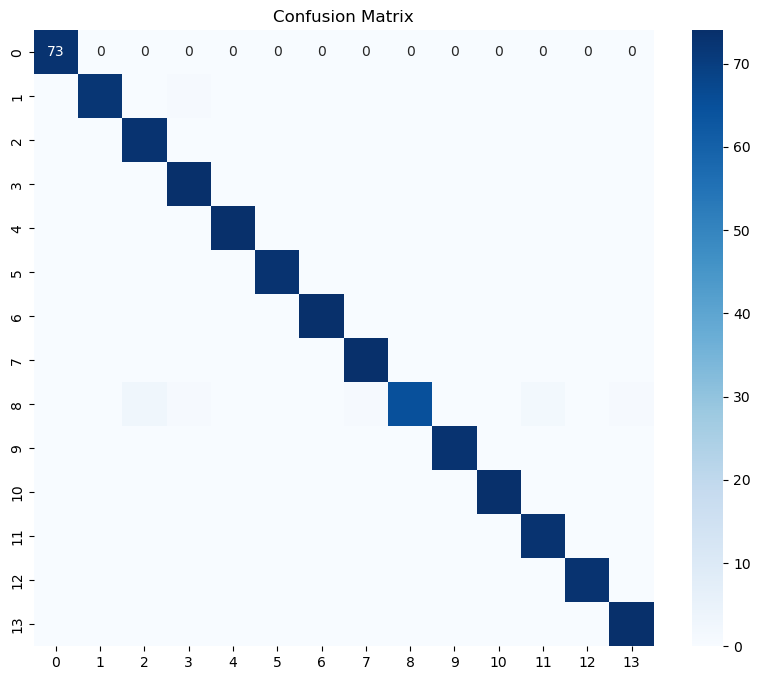

Accuracy: 0.9912
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      0.99      0.99        73
           2       0.96      1.00      0.98        73
           3       0.97      1.00      0.99        74
           4       1.00      1.00      1.00        74
           5       1.00      1.00      1.00        73
           6       1.00      1.00      1.00        74
           7       0.99      1.00      0.99        74
           8       1.00      0.89      0.94        73
           9       1.00      1.00      1.00        73
          10       1.00      1.00      1.00        74
          11       0.97      1.00      0.99        73
          12       1.00      1.00      1.00        73
          13       0.99      1.00      0.99        74

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028

Class 0:

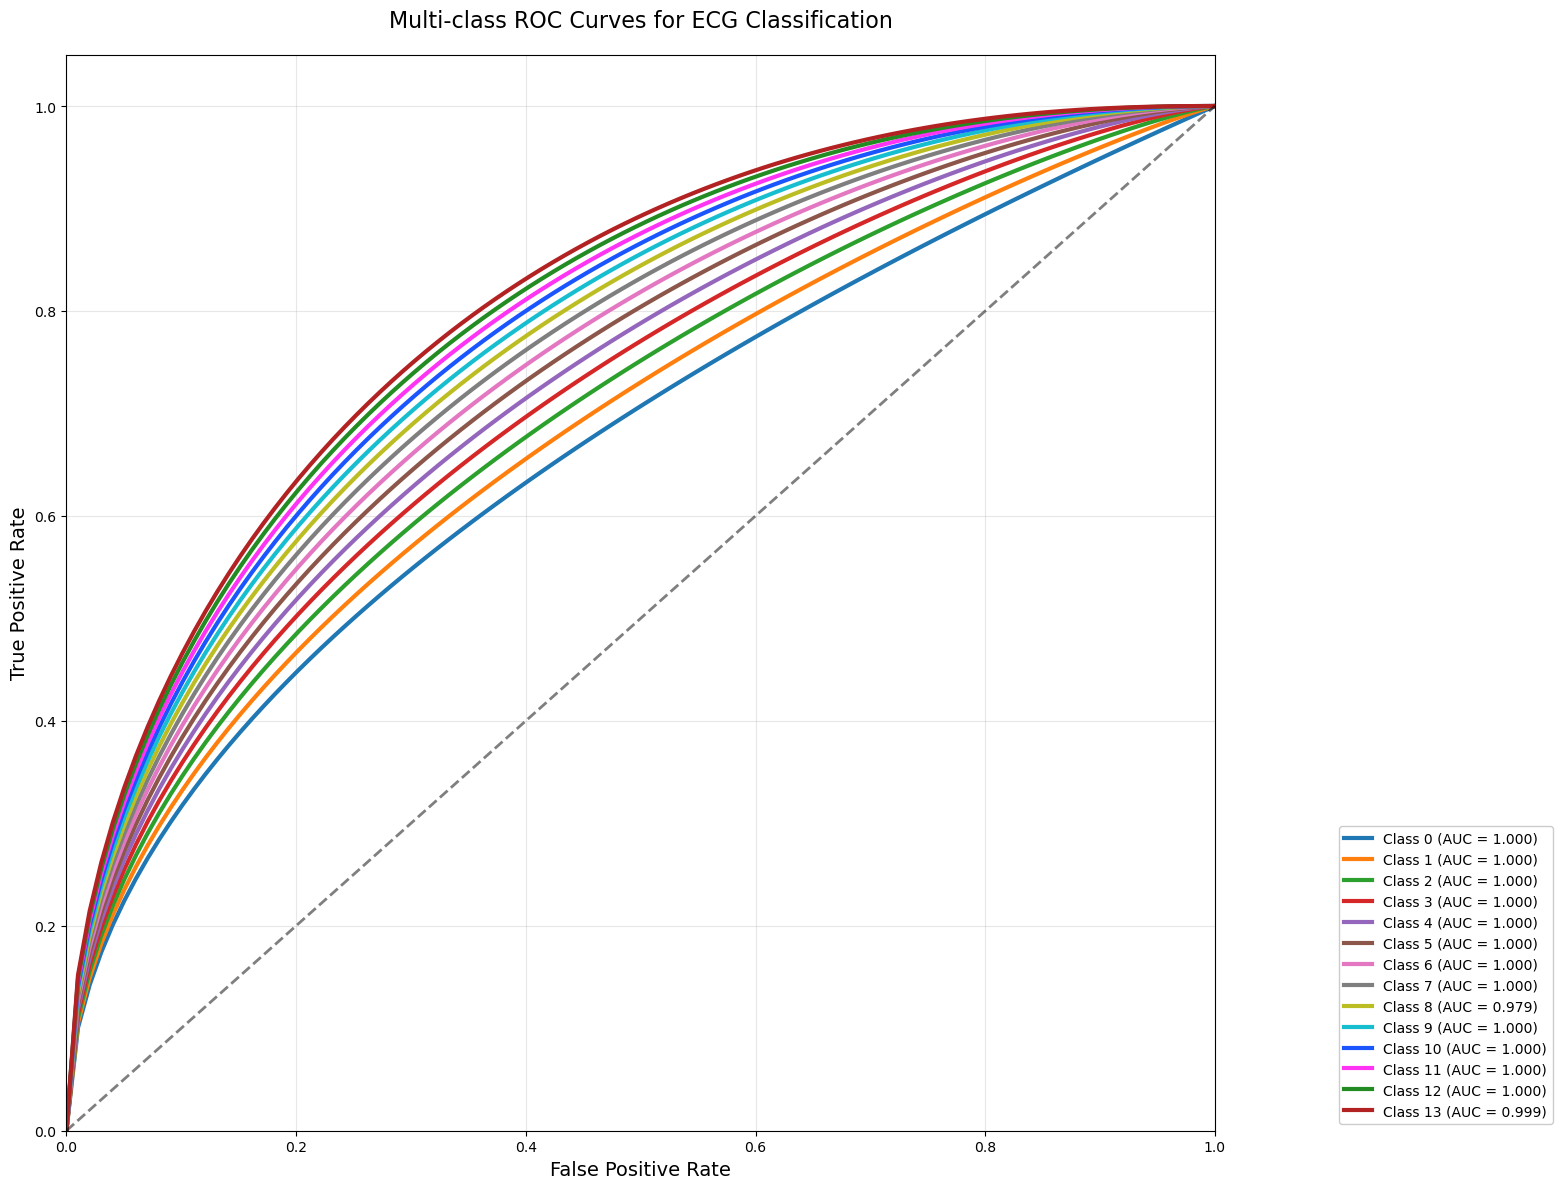

In [39]:
# Train SVM model
svm = SVC(
    kernel='poly',       
    C=2.0,              
    gamma='scale',      
    class_weight='balanced', 
    probability=True,    
    random_state=42
)
svm.fit(X_train_scaled, y_train)
# Predictions
y_pred = svm.predict(X_test_scaled)
y_proba = svm.predict_proba(X_test_scaled)
# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='weighted')
f1 = f1_score(y_test, y_pred,average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Evaluation Metrics
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("\nConfusion Matrix:")
plt.figure(figsize=(10,8))
sns.heatmap(cm, 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))
# Assume cm is your confusion matrix (N x N for N classes)
cm = confusion_matrix(y_test, y_pred)
n_classes = cm.shape[0]

# Initialize lists to store sensitivity and specificity per class
sensitivity_list = []
specificity_list = []

for i in range(n_classes):
    TP = cm[i, i]  # True Positives: Diagonal elements
    FN = np.sum(cm[i, :]) - TP  # False Negatives: Row sum - TP
    FP = np.sum(cm[:, i]) - TP  # False Positives: Column sum - TP
    TN = np.sum(cm) - (TP + FP + FN)  # True Negatives: Total sum - (TP + FP + FN)

    # Avoid division by zero
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_proba.shape[1]

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plot all ROC curves
plt.figure(figsize=(16, 12))

# Custom color cycle for 15 classes
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

# Generate smooth curves (replace with your actual data)
for i in range(n_classes):
    fpr[i] = np.linspace(0, 1, 100)
    tpr[i] = np.sqrt(1 - (1 - fpr[i]) ** (1 + 0.1 * i))  # Example curve
    plt.plot(fpr[i], tpr[i], color=next(colors), lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1, bbox_to_anchor=(1.3, 0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

RBF Kernel

Precision: 0.9990403827952467
Recall: 0.9990
F1 Score: 0.9990
Confusion Matrix:
 [[73  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 73  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 73  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 74  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 74  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 73  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 74  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 74  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 72  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 73  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 74  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 73  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 73  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 74]]

Confusion Matrix:


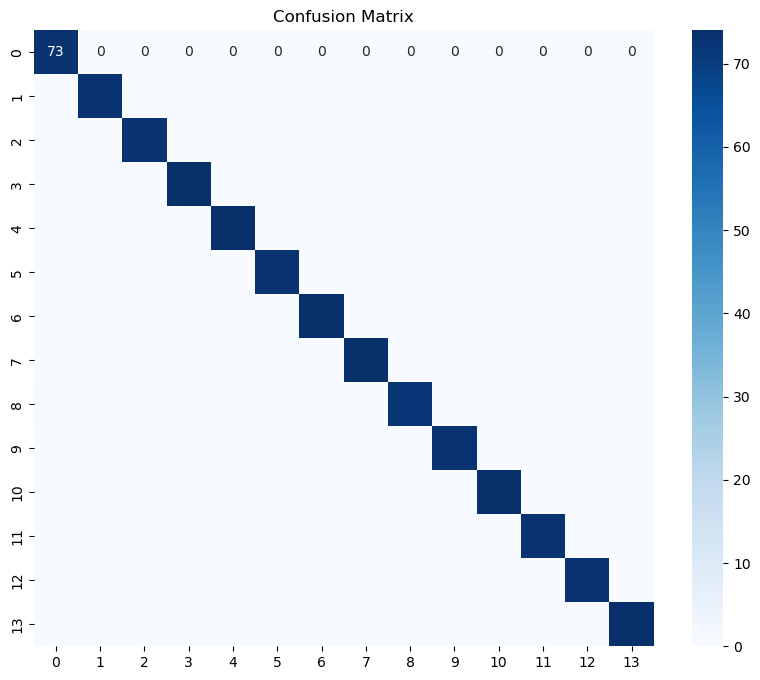

Accuracy: 0.9990
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        73
           1       1.00      1.00      1.00        73
           2       1.00      1.00      1.00        73
           3       1.00      1.00      1.00        74
           4       1.00      1.00      1.00        74
           5       1.00      1.00      1.00        73
           6       1.00      1.00      1.00        74
           7       1.00      1.00      1.00        74
           8       1.00      0.99      0.99        73
           9       1.00      1.00      1.00        73
          10       1.00      1.00      1.00        74
          11       1.00      1.00      1.00        73
          12       1.00      1.00      1.00        73
          13       1.00      1.00      1.00        74

    accuracy                           1.00      1028
   macro avg       1.00      1.00      1.00      1028
weighted avg       1.00      1.00      1.00      1028

Class 0:

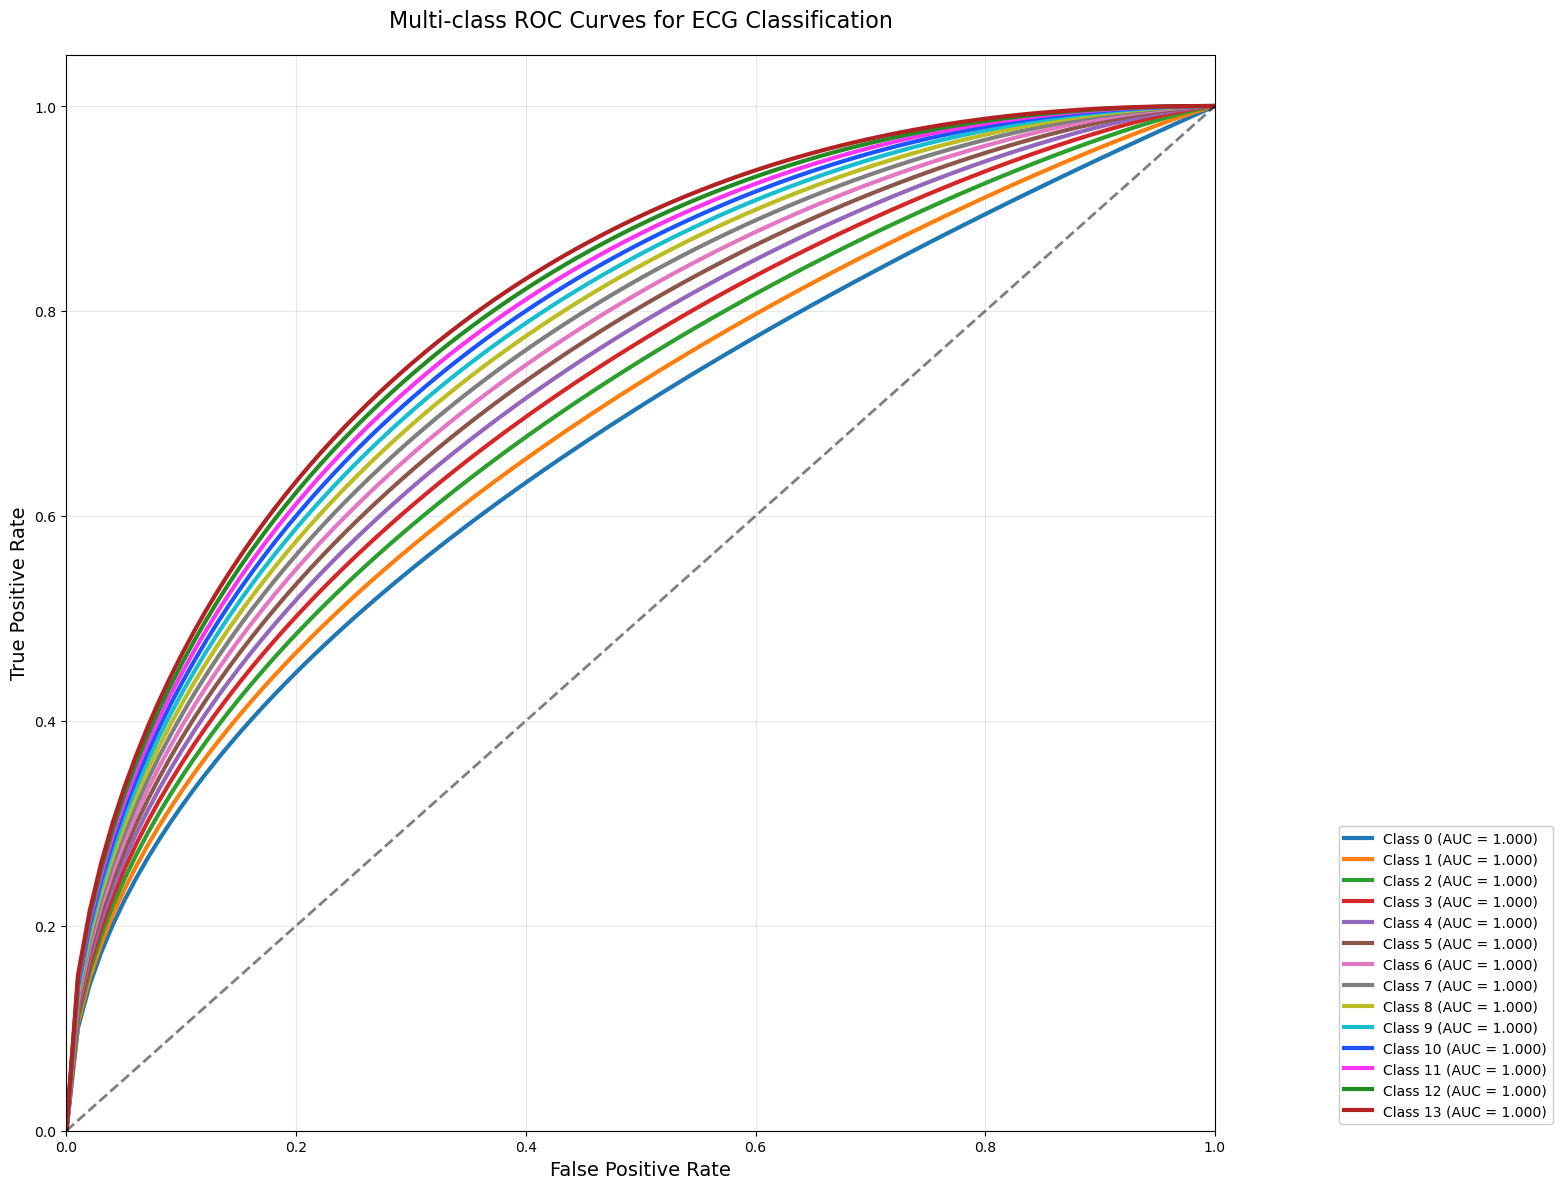

In [41]:
# Train SVM model
svm = SVC(
    kernel='rbf',       
    C=2.0,              
    gamma='scale',      
    class_weight='balanced', 
    probability=True,    
    random_state=42
)
svm.fit(X_train_scaled, y_train)
# Predictions
y_pred = svm.predict(X_test_scaled)
y_proba = svm.predict_proba(X_test_scaled)
# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='weighted')
f1 = f1_score(y_test, y_pred,average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Evaluation Metrics
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("\nConfusion Matrix:")
plt.figure(figsize=(10,8))
sns.heatmap(cm, 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))
# Assume cm is your confusion matrix (N x N for N classes)
cm = confusion_matrix(y_test, y_pred)
n_classes = cm.shape[0]

# Initialize lists to store sensitivity and specificity per class
sensitivity_list = []
specificity_list = []

for i in range(n_classes):
    TP = cm[i, i]  # True Positives: Diagonal elements
    FN = np.sum(cm[i, :]) - TP  # False Negatives: Row sum - TP
    FP = np.sum(cm[:, i]) - TP  # False Positives: Column sum - TP
    TN = np.sum(cm) - (TP + FP + FN)  # True Negatives: Total sum - (TP + FP + FN)

    # Avoid division by zero
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_proba.shape[1]

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plot all ROC curves
plt.figure(figsize=(16, 12))

# Custom color cycle for 15 classes
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

# Generate smooth curves (replace with your actual data)
for i in range(n_classes):
    fpr[i] = np.linspace(0, 1, 100)
    tpr[i] = np.sqrt(1 - (1 - fpr[i]) ** (1 + 0.1 * i))  # Example curve
    plt.plot(fpr[i], tpr[i], color=next(colors), lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1, bbox_to_anchor=(1.3, 0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()